# Grover's search and random walks

This document contains:  
1) Grover's algorithm for search in a general case.  
2) Grover's algorithm as a hamiltonian simulation.  
2) Random walks and grover's algorithm.  

## Getting started
Lets initialize required packages and modules. Make sure you have installed Python3, qiskit.

In [1]:
# Initializations
import numpy as np
import array
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

## Problem statement  
You are given a database with N elements and you need to find whether an item(s) is present. Classically, you can determine if so by checking each element individually, and this method would take $O(N)$ steps on average. Here steps are quantified by the number of checks to see if it's the element we are looking for. In other terms, number of oracle uses.  
Grover's algorithm can acheive this by $O(\sqrt{N})$ oracle uses. An oracle is a black box sort of system that is used to check if the current input is the desired object. Since for a quantum gate, it needs to be reversible, we construct the Oracle such that it adds a negative phase to states that are a solution. and leaves the rest unchanged.  $$O(|x\rangle + |x^\perp\rangle) =  -|x\rangle + |x^\perp\rangle.$$ This gives an Oracle of the form $O = -|x\rangle\langle x| + |x^\perp\rangle\langle x^\perp | = I - 2|x\rangle\langle x|$  

You might be wondering, if you know the answer, what are we exactly trying to acheive? All that we are doing in the oracle is that we are checking if the current string is the solution or not and adding a phase to it.

It can be constructed with a conditional NOT gate acting on a $|-\rangle$ state as shown below for a 2 qubit gate to select state $|01\rangle$:

In [2]:
#Simple 2 qubit oracle
def oracle_10(circuit, ancilla):
    circuit.x(0)
    circuit.ccx(0, 1, ancilla-1)
    circuit.x(0)

# to parse binary strings to lists
def parse_string(string):
    l = []
    for a in range(len(string)):
        l.append(int(string[a], 2))
    return l

#generalized CnNOT gate with multiple controls and targets
def CnNOT(circuit, control, target, ancilla): #control, target and ancilla is a list of qubit locations
    c = len(control)
    t = len(target)
    a = len(ancilla)
    if a < c - 1:
        raise ValueError("insufficient ancilla")
    if c == 1:
        for x in range(t):        
            circuit.cx(control[0], target[x])
    if c == 2:
        for x in range(t):        
            circuit.ccx(control[0], control[1], target[x])
    if c > 2:
        circuit.ccx(control[0], control[1], ancilla[0])
        for x in range(2,c):
            circuit.ccx(control[x], ancilla[x-2], ancilla[x-1])
        for x in range(t):
            circuit.cx(ancilla[c-2], target[x])
        for x in range(c-1, 1, -1):
            circuit.ccx(control[x], ancilla[x-2], ancilla[x-1])
        circuit.ccx(control[0], control[1], ancilla[0])

#generalized oracle
def oracle_gen(circuit, string, control, t_ancilla, ancilla): # here string denotes the binary 
    s = len(string)
    for x in range(s):    
        ans = parse_string(string[x])
        for a in range(len(string[x])):
            if ans[a] == 0:
                circuit.x(a)
        
        CnNOT(circuit, control, t_ancilla, ancilla)

        for a in range(len(string[x])):
            if ans[a] == 0:
                circuit.x(a)

#testing purposes
n = 5
circ = QuantumCircuit(2*n, n)
control = range(0, n)
ancilla = range(n+1, 2*n)
t_ancilla = [n]
string = ['11010', '01100']
oracle_gen(circ, string, control, t_ancilla, ancilla)
circuit_drawer(circ)

┌───┐     »
q_0: |0>───────■─────────────────────────────────────────────────■──┤ X ├──■──»
               │                                                 │  └───┘  │  »
q_1: |0>───────■─────────────────────────────────────────────────■─────────■──»
        ┌───┐  │                                          ┌───┐  │         │  »
q_2: |0>┤ X ├──┼────■──────────────────────────────────■──┤ X ├──┼─────────┼──»
        └───┘  │    │                           ┌───┐  │  └───┘  │         │  »
q_3: |0>───────┼────┼────■───────────────────■──┤ X ├──┼─────────┼─────────┼──»
        ┌───┐  │    │    │                   │  ├───┤  │  ┌───┐  │         │  »
q_4: |0>┤ X ├──┼────┼────┼────■─────────■────┼──┤ X ├──┼──┤ X ├──┼─────────┼──»
        └───┘  │    │    │    │  ┌───┐  │    │  └───┘  │  └───┘  │         │  »
q_5: |0>───────┼────┼────┼────┼──┤ X ├──┼────┼─────────┼─────────┼─────────┼──»
             ┌─┴─┐  │    │    │  └─┬─┘  │    │         │       ┌─┴─┐     ┌─┴─┐»
q_6: |0>─────┤ X ├──■────┼────┼────┼────┼────┼─────────■───────┤ X ├─────┤ X ├»
             └───┘┌─┴─┐  │    │    │    │    │       ┌─┴─┐     └───┘     └───┘»
q_7: |0>──────────┤ X ├──■────┼────┼────┼────■───────┤ X ├────────────────────»
                  └───┘┌─┴─┐  │    │    │  ┌─┴─┐     └───┘                    »
q_8: |0>───────────────┤ X ├──■────┼────■──┤ X ├──────────────────────────────»
                       └───┘┌─┴─┐  │  ┌─┴─┐└───┘                              »
q_9: |0>────────────────────┤ X ├──■──┤ X ├───────────────────────────────────»
                            └───┘     └───┘                                   »
 c_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                              »
 c_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                              »
 c_2: 0 ══════════════════════════════════════════════════════════════════════»
                                                                              »
 c_3: 0 ══════════════════════════════════════════════════════════════════════»
                                                                              »
 c_4: 0 ══════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                  ┌───┐
«q_0: ──────────────────────────────────────────■──┤ X ├
«                                               │  └───┘
«q_1: ──────────────────────────────────────────■───────
«                                               │       
«q_2: ──■──────────────────────────────────■────┼───────
«       │                           ┌───┐  │    │       
«q_3: ──┼────■───────────────────■──┤ X ├──┼────┼───────
«       │    │                   │  ├───┤  │    │       
«q_4: ──┼────┼────■─────────■────┼──┤ X ├──┼────┼───────
«       │    │    │  ┌───┐  │    │  └───┘  │    │       
«q_5: ──┼────┼────┼──┤ X ├──┼────┼─────────┼────┼───────
«       │    │    │  └─┬─┘  │    │         │  ┌─┴─┐     
«q_6: ──■────┼────┼────┼────┼────┼─────────■──┤ X ├─────
«     ┌─┴─┐  │    │    │    │    │       ┌─┴─┐└───┘     
«q_7: ┤ X ├──■────┼────┼────┼────■───────┤ X ├──────────
«     └───┘┌─┴─┐  │    │    │  ┌─┴─┐     └───┘          
«q_8: ─────┤ X ├──■────┼────■──┤ X ├────────────────────
«          └───┘┌─┴─┐  │  ┌─┴─┐└───┘                    
«q_9: ──────────┤ X ├──■──┤ X ├─────────────────────────
«               └───┘     └───┘                         
«c_0: ══════════════════════════════════════════════════
«                                                       
«c_1: ══════════════════════════════════════════════════
«                                                       
«c_2: ══════════════════════════════════════════════════
«                                                       
«c_3: ═══════════════════════════════════════════

Let's get straight into constructing the circuit. Starting with a uniform superposition of qubit states, we apply an iteration of the oracle, then apply a reflection about the initial all superposed state.  
Repeating this step a certain number of times, depending on the number of solutions (M out of N). The expression for the number of iterations is given by  $k = \lceil{\frac{\pi}{4}\sqrt{\frac{2^n}{M}}}\rceil$

In [3]:
def reflection(circuit, control, t_ancilla, ancilla): #ancilla here is a list of locations of the ancilla
    for a in control:
        circuit.h(a)
        circuit.x(a)
    
    CnNOT(circuit, control, t_ancilla, ancilla)
    
    for a in control:
        circuit.x(a)
        circuit.h(a)
    
#testing purposes
circu = QuantumCircuit(4, 1)
circu.h(2)
reflection(circu, [0, 1], [2], [3])
circuit_drawer(circu)

┌───┐┌───┐     ┌───┐┌───┐
q_0: |0>┤ H ├┤ X ├──■──┤ X ├┤ H ├
        ├───┤├───┤  │  ├───┤├───┤
q_1: |0>┤ H ├┤ X ├──■──┤ X ├┤ H ├
        ├───┤└───┘┌─┴─┐└───┘└───┘
q_2: |0>┤ H ├─────┤ X ├──────────
        └───┘     └───┘          
q_3: |0>─────────────────────────
                                 
 c_0: 0 ═════════════════════════

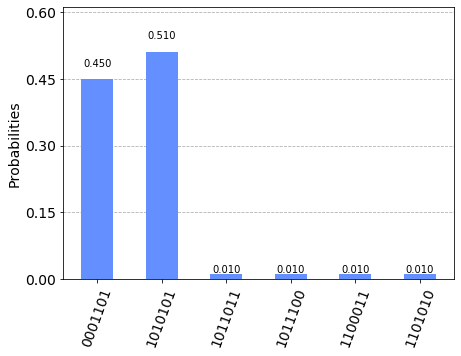

In [4]:
def grover(circuit, string, control, t_ancilla, ancilla):
    for a in control:
        circuit.h(a)
    for a in t_ancilla:
        circuit.x(a)
        circuit.h(a)
    n = len(control)
    M = len(string)
    k = int(np.ceil((np.pi/4)*(np.sqrt(2**n/M))))
    #k = 1
    for a in range(k):
        oracle_gen(circuit, string, control, t_ancilla, ancilla)
        reflection(circuit, control, t_ancilla, ancilla)
    for a in range(n):
        circuit_g.measure(control[a], [a])

# # #
string = ['1011000', '1010101']
n = len(string[0])
circuit_g = QuantumCircuit(2*n, n)
control = range(0, n)
ancilla = range(n+1, 2*n)
t_ancilla = [n]

grover(circuit_g, string, control, t_ancilla, ancilla)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit_g, backend, shots= 100)
plot_histogram(job.result().get_counts(circuit_g))
#circuit_drawer(circuit_g)

Need to do next:  
1) Start with a database for it to search on, and initialise the super position state with that.  
2) Quantum counting with phase estimation.